In [1]:
from pathlib import Path

import IPython.display as ipd
import librosa
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import numpy as np

In [2]:
IN_FILE = Path("data/gaffigan-short.wav")
LAUGH_FILE = Path(f"data/{IN_FILE.stem}_Instruments.wav")
VOCAL_FILE = Path(f"data/{IN_FILE.stem}_Vocals.wav")


# if not LAUGH_FILE.exists():
#     ! python inference.py --input {IN_FILE} --output_image

#     ! mv {IN_FILE.stem}*.wav data/
#     ! mv {IN_FILE.stem}*.jpg data/

In [3]:
laugh_x, laugh_Fs = librosa.load(str(LAUGH_FILE), sr=None)
vocal_x, vocal_Fs = librosa.load(str(VOCAL_FILE), sr=None)

<AxesSubplot:>

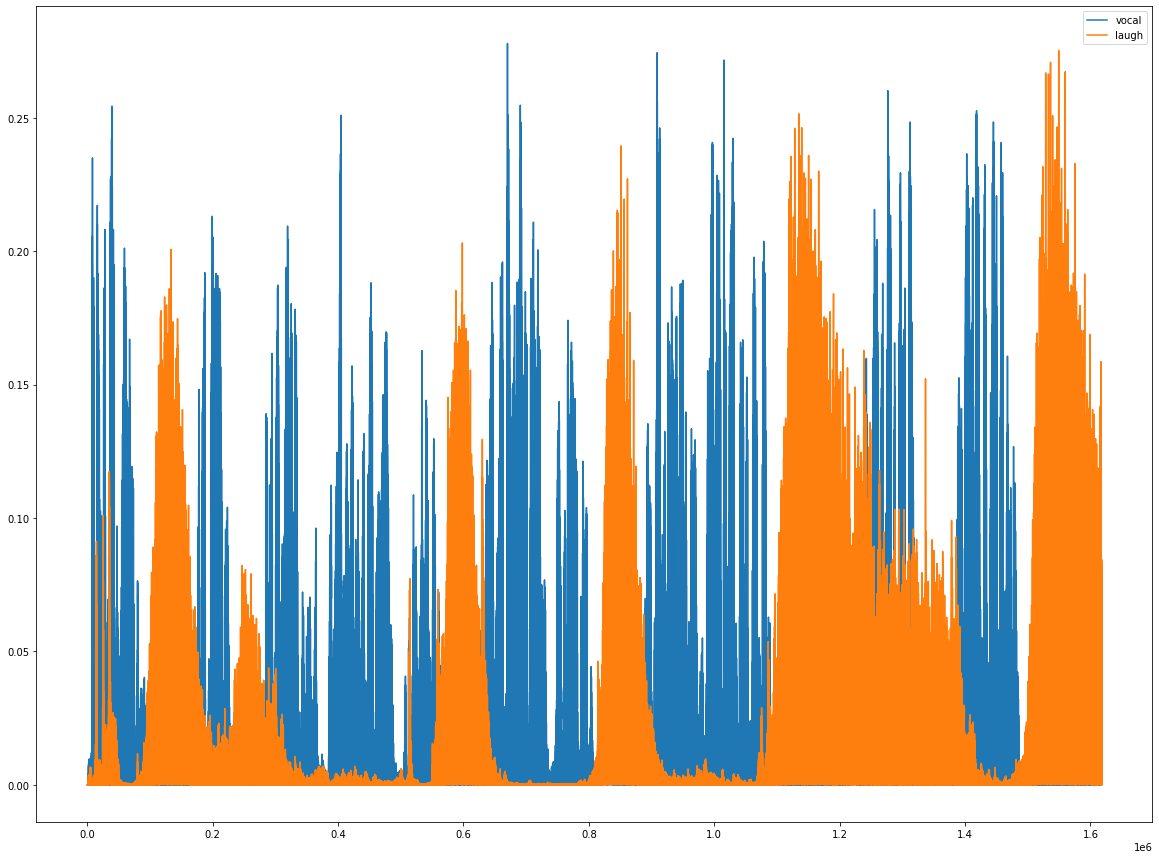

In [4]:
laugh_magnitude, laugh_phase = librosa.magphase(laugh_x)
vocal_magnitude, vocal_phase = librosa.magphase(vocal_x)
df = pd.DataFrame(
    np.stack((vocal_magnitude, laugh_magnitude)).T, columns=["vocal", "laugh"]
)
df.plot(figsize=(20, 15))

(16180, 2)


<AxesSubplot:>

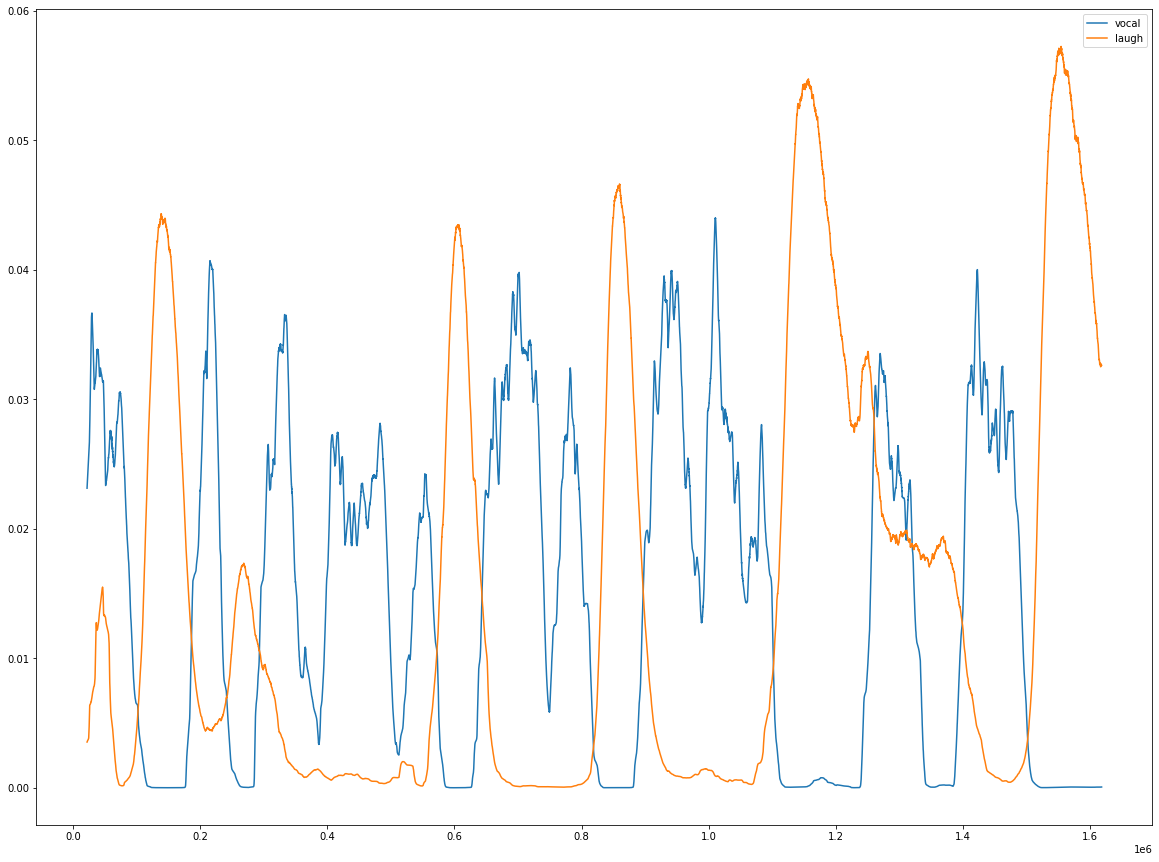

In [5]:
smooth = df.rolling(laugh_Fs // 2).mean()[::100]
print(smooth.shape)
smooth.plot(figsize=(20, 15))

In [6]:
# importing libraries
import os

import speech_recognition as sr
from pydub import AudioSegment
from pydub.silence import split_on_silence
from pydub.utils import make_chunks

# create a speech recognition object
r = sr.Recognizer()


# open the audio file using pydub
sound = AudioSegment.from_wav(str(IN_FILE))
# split audio sound where silence is 700 miliseconds or more and get chunks
chunks = split_on_silence(
    sound,
    # experiment with this value for your target audio file
    min_silence_len=100,
    # adjust this per requirement
    silence_thresh=sound.dBFS - 14,
    # keep the silence for 1 second, adjustable as well
    keep_silence=True,
)
folder_name = "audio-chunks"
# create a directory to store the audio chunks
if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
whole_text = ""
# process each chunk
out = []
timer = 0.0
for i, audio_chunk in enumerate(chunks, start=1):
    text = ""

    # export audio chunk and save it in
    # the `folder_name` directory.
    chunk_filename = os.path.join(folder_name, f"chunk{i}.wav")
    audio_chunk.export(chunk_filename, format="wav")
    # recognize the chunk
    with sr.AudioFile(chunk_filename) as source:
        audio_listened = r.record(source)
        # try converting it to text
        try:
            text = r.recognize_google(audio_listened)
        except sr.UnknownValueError as e:
            print(chunk_filename, ": Error:", str(e))
    timer2 = timer + audio_chunk.duration_seconds
    out.append((timer, timer2, text))
    timer = timer2


audio-chunks/chunk3.wav : Error: 
audio-chunks/chunk4.wav : Error: 
audio-chunks/chunk7.wav : Error: 
audio-chunks/chunk9.wav : Error: 
audio-chunks/chunk11.wav : Error: 
audio-chunks/chunk14.wav : Error: 
audio-chunks/chunk16.wav : Error: 


In [7]:
out

[(0.0, 1.755, 'I do sometimes lie'),
 (1.755, 7.703, "I'm not proud of it but sometimes we all have"),
 (7.703, 8.142, ''),
 (8.142, 8.524999999999999, ''),
 (8.524999999999999, 10.396999999999998, 'you want to tell my children'),
 (10.396999999999998, 11.336999999999998, 'July'),
 (11.336999999999998, 11.961999999999998, ''),
 (11.961999999999998, 16.781, 'lying. I should never lie to a child'),
 (16.781, 17.185, ''),
 (17.185, 17.807, "people don't"),
 (17.807, 18.278, ''),
 (18.278, 22.329, 'kids you lied to him all the time'),
 (22.329, 23.534, "you weren't like this"),
 (23.534, 23.971999999999998, ''),
 (23.971999999999998, 33.824, 'very spicy'),
 (33.824, 36.708, '')]

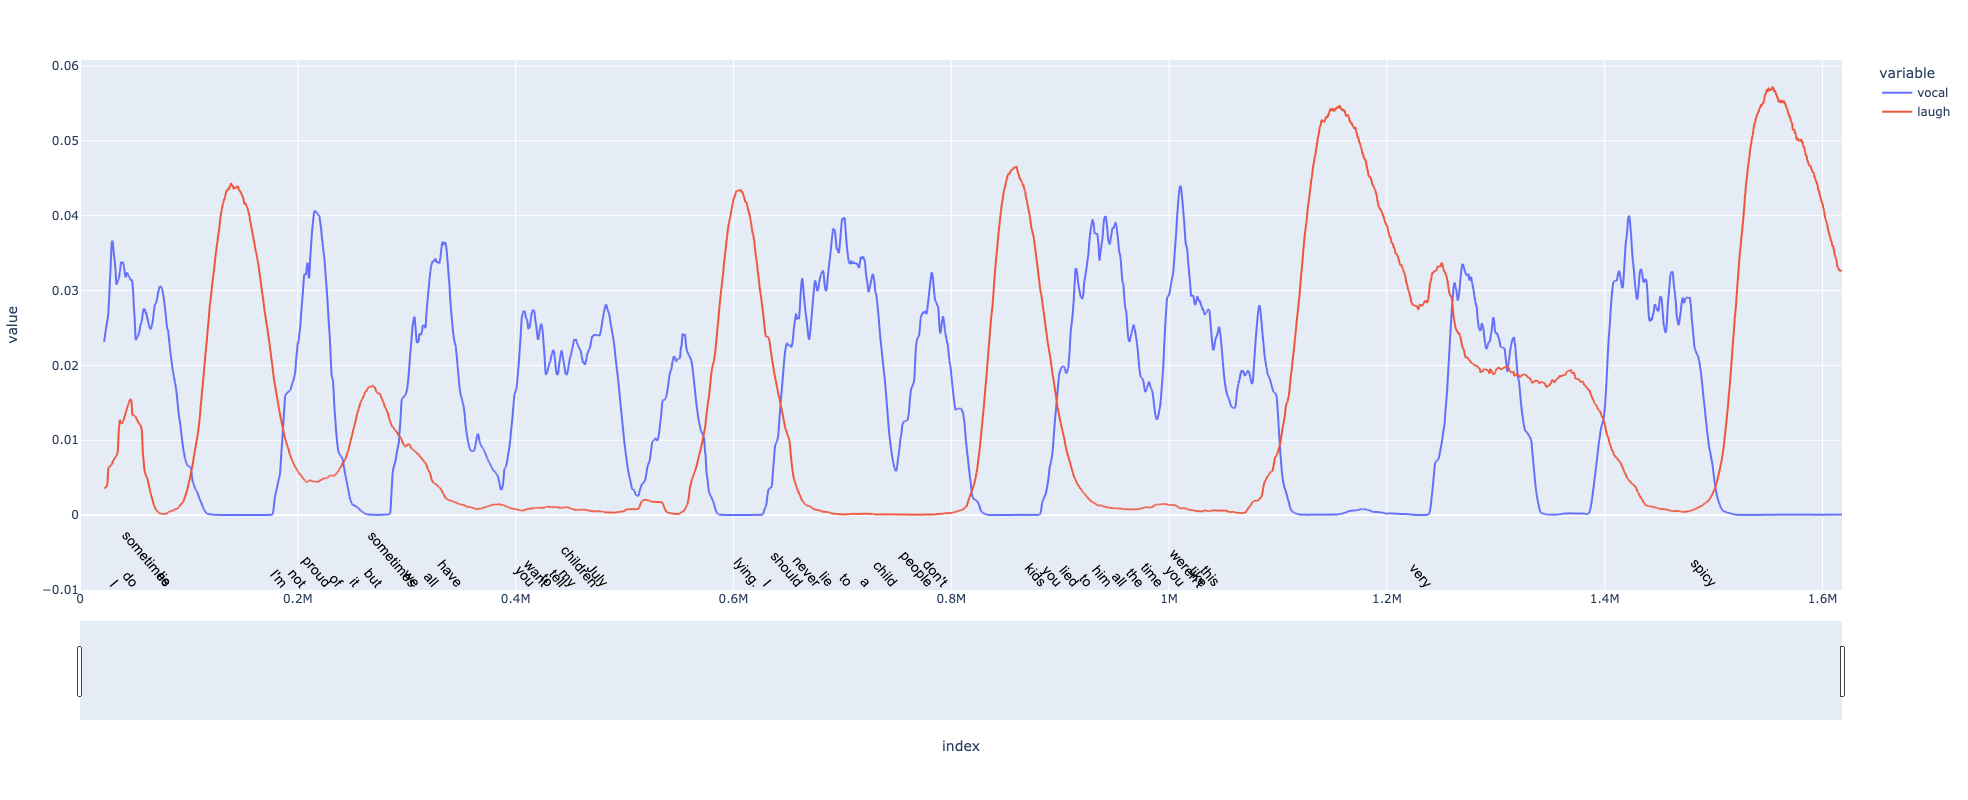

In [8]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


ind = 0
rate = laugh_Fs
px_fig = px.line(
    smooth,
    width=2000,
    height=800,
    # title=words,
    # text=words,
)
annotations = []
for start, end, words in out:
    ind += 1

    nwords = len(words.split())
    duration = end - start
    annotations += [
        go.layout.Annotation(
            x=x,
            y=-.01,
            # mode="text",
            text=word,
            # textposition="bottom center",
            font_size=14,
            font_family="Arial",
            font_color="black",
            yanchor="bottom",
            textangle=50,
            showarrow=False,
            borderwidth=0,
            borderpad=0,
            # yanchor='bottom',
        )
        for x, y, word in zip(
            np.linspace((start + .4 * duration) * rate, end * rate, nwords),
            np.repeat(smooth.max().to_numpy(), nwords),
            words.split(),
        )
    ]
px_fig.update_layout(
    xaxis=dict(rangeslider=dict(visible=True), type="linear"),
    annotations=annotations,
    # yaxis={"range":[0,.0028]}
)
px_fig.show()

In [16]:
px_fig.write_html("output_chart.html")

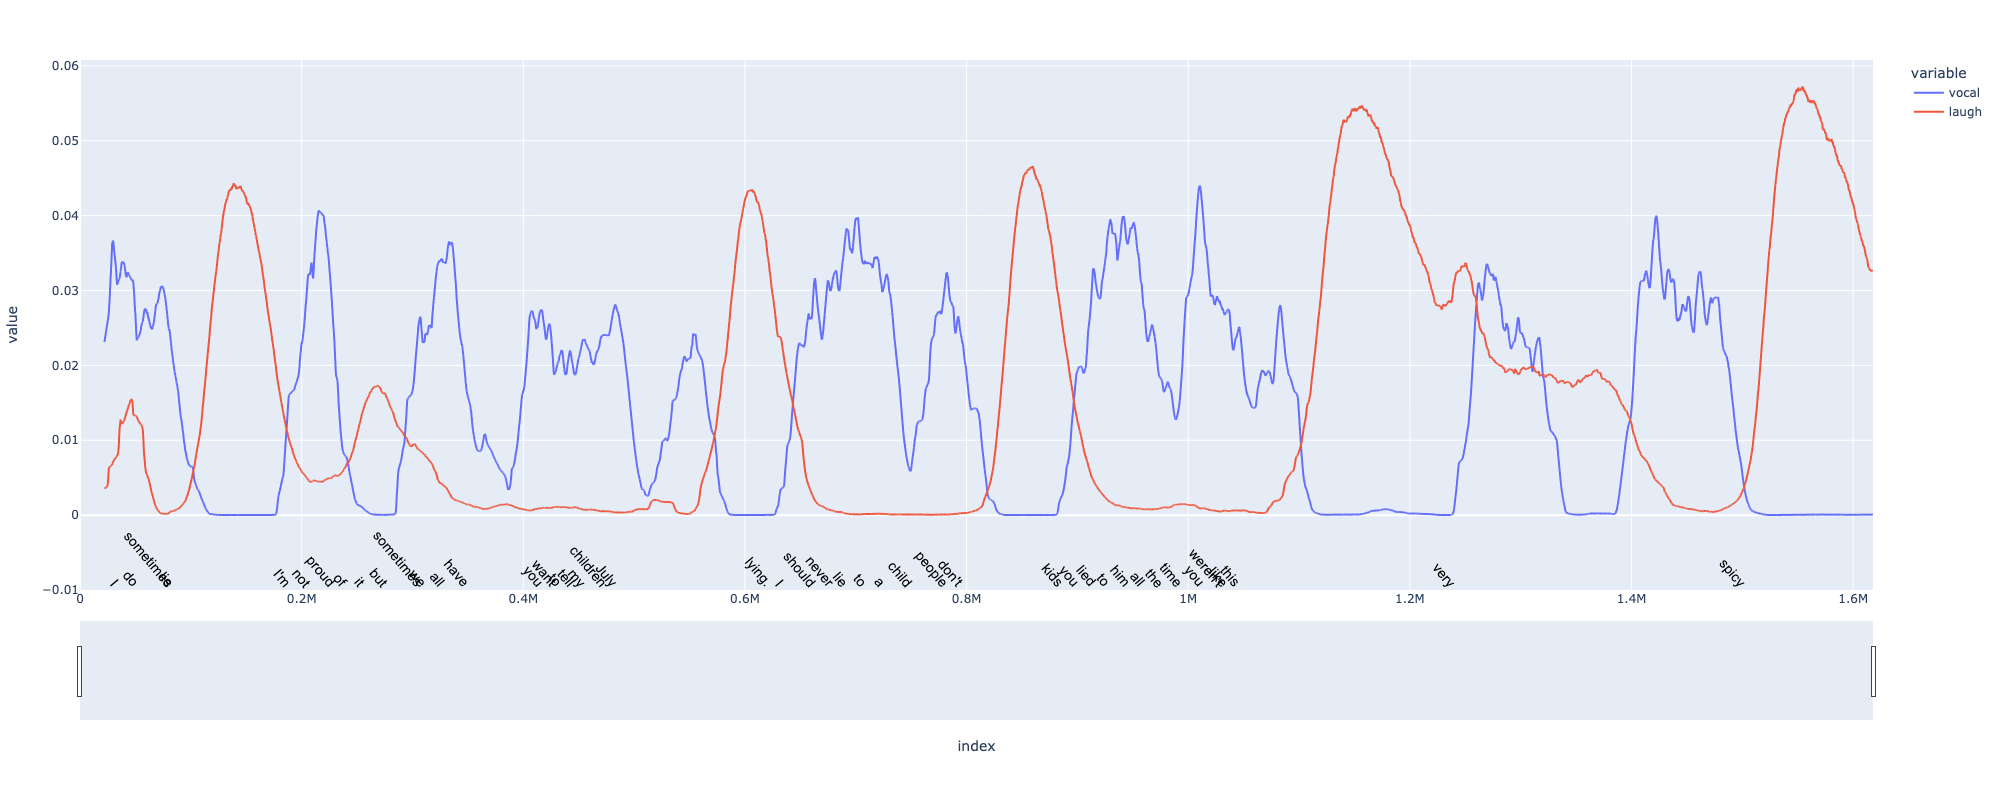

In [25]:
Image.open("image.png")

In [24]:
px_fig.write_image("image.png")